C:\Users\Jack Zhang\AppData\Local\Temp\ipykernel_7600\1694154640.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil['dcoilwtico'] = pd.to_numeric(oil['dcoilwtico'], errors='coerce').fillna(method='ffill')
C:\Users\Jack Zhang\AppData\Local\Temp\ipykernel_7600\1694154640.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type_original', y='sales', data=train, showfliers=False, palette='coolwarm')


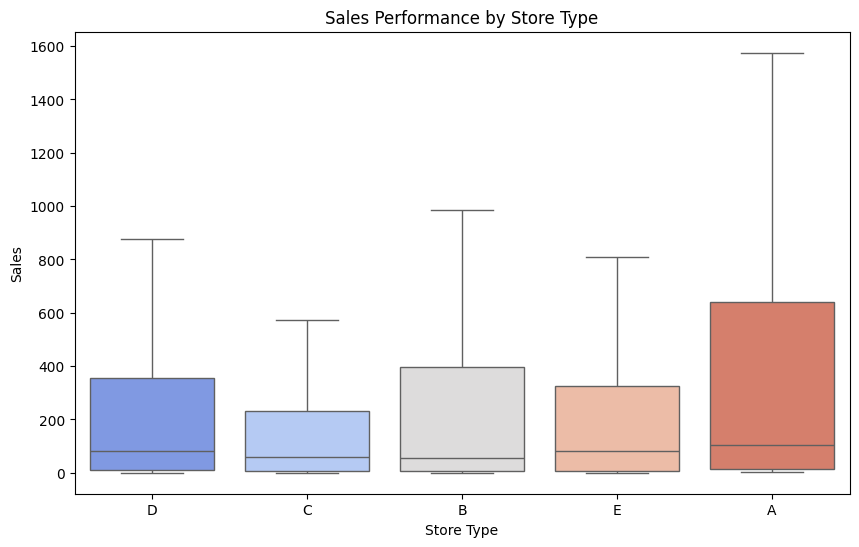

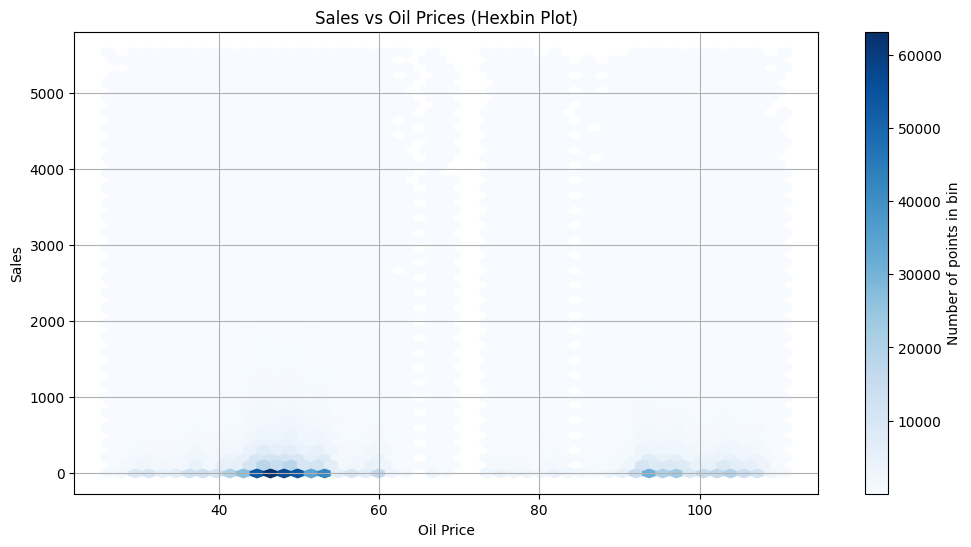

C:\Users\Jack Zhang\AppData\Local\Temp\ipykernel_7600\1694154640.py:82: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='type_original', y='store_sales_avg', data=ordered_data, ci='sd', palette='viridis')
C:\Users\Jack Zhang\AppData\Local\Temp\ipykernel_7600\1694154640.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='type_original', y='store_sales_avg', data=ordered_data, ci='sd', palette='viridis')


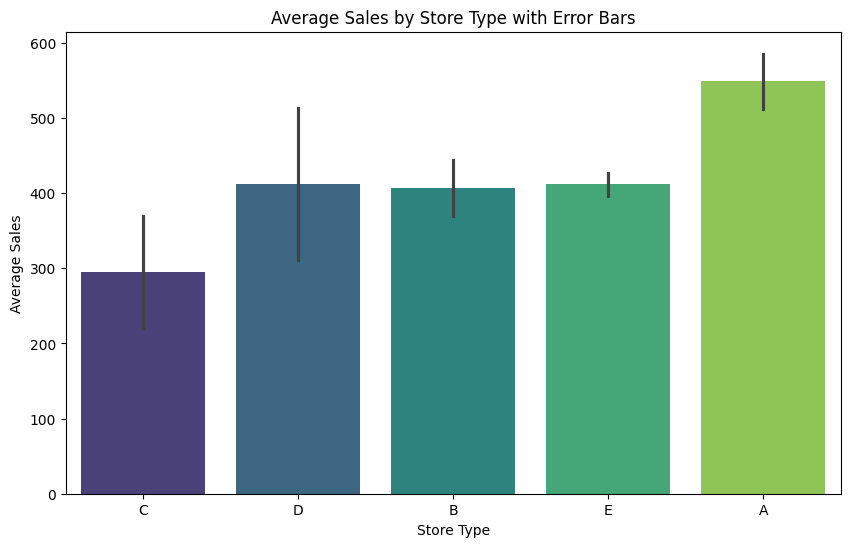

C:\Users\Jack Zhang\AppData\Local\Temp\ipykernel_7600\1694154640.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type_holiday', y='sales', data=train, palette='pastel')


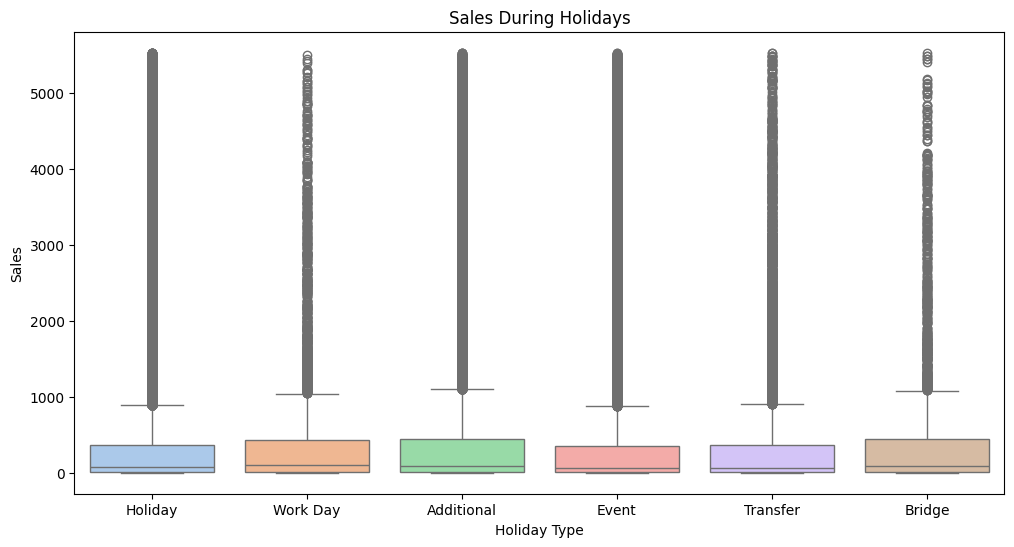

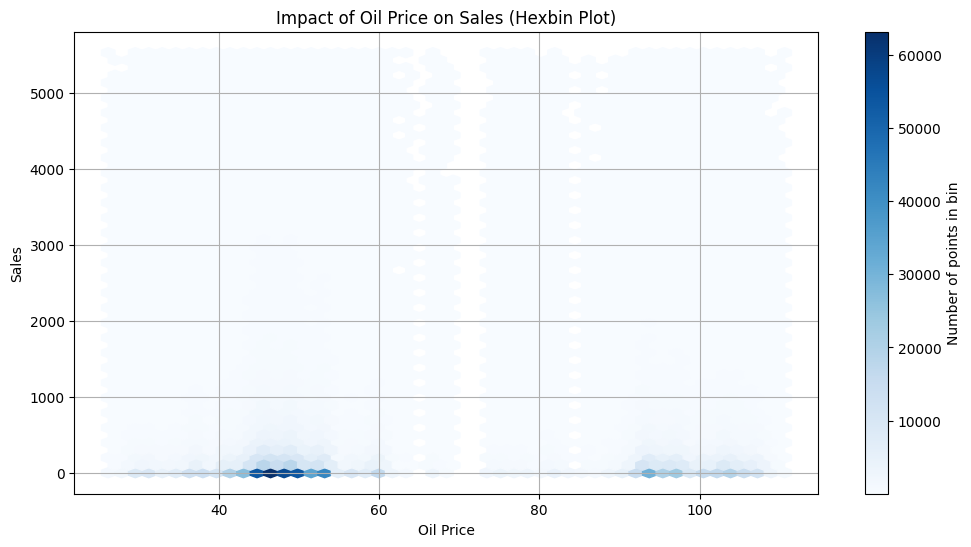

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据
oil = pd.read_csv('oil.csv')
holidays = pd.read_csv('holidays_events.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
transactions = pd.read_csv('transactions.csv')

# 1. 处理 oil.csv
oil['date'] = pd.to_datetime(oil['date'])
oil['dcoilwtico'] = pd.to_numeric(oil['dcoilwtico'], errors='coerce').fillna(method='ffill')

# 2. 处理 holiday_events.csv
holidays['date'] = pd.to_datetime(holidays['date'])
holidays['transferred'] = holidays['transferred'].astype(bool)
holidays['type_holiday']= holidays['type']

# 3. 处理 stores.csv
stores['type_original'] = stores['type'] 
stores['city'] = stores['city'].astype('category').cat.codes
stores['state'] = stores['state'].astype('category').cat.codes
stores['type'] = stores['type'].astype('category').cat.codes
stores['cluster'] = stores['cluster'].astype('category').cat.codes

# 4. 处理 test.csv 和 train.csv
for df in [test, train]:
    df['date'] = pd.to_datetime(df['date'])
    df['onpromotion'] = df['onpromotion'].astype(int)
    df['family'] = df['family'].astype('category').cat.codes
    # 提取年、月、日
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek

# 5. 处理 transactions.csv
transactions['date'] = pd.to_datetime(transactions['date'])

# 数据集联接
train = pd.merge(train, holidays, on='date', how='left', suffixes=('', '_holiday'))
train = pd.merge(train, oil, on='date', how='left')
train = pd.merge(train, stores, on='store_nbr', how='left')

# 异常值处理 -移除或修正异常的销售量
q_low = train['sales'].quantile(0.01)
q_hi  = train['sales'].quantile(0.99)
train = train[(train['sales'] > q_low) & (train['sales'] < q_hi)]

# 创建基于现有数据的新特征 - 一个表示是否是促销日的特征
train['is_promo'] = train['onpromotion'].apply(lambda x: 1 if x > 0 else 0)
# 创建新特征，例如每个商店的平均销售量
store_sales_avg = train.groupby('store_nbr')['sales'].mean().reset_index()
store_sales_avg.rename(columns={'sales': 'store_sales_avg'}, inplace=True)
train = pd.merge(train, store_sales_avg, on='store_nbr', how='left')

#探索性数据分析（EDA）：使用统计摘要和可视化方法来探索数据的主要特征，如分布、趋势和关联性。
# Sales Performance by Store Type with potential outliers removed
plt.figure(figsize=(10, 6))
sns.boxplot(x='type_original', y='sales', data=train, showfliers=False, palette='coolwarm')
plt.title('Sales Performance by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

# 油价与销售量的关系
plt.figure(figsize=(12, 6))
hb = plt.hexbin(train['dcoilwtico'], train['sales'], gridsize=50, cmap='Blues', mincnt=1)
plt.colorbar(hb, label='Number of points in bin')
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.title('Sales vs Oil Prices (Hexbin Plot)')
plt.grid(True)
plt.show()

# 商店类型与其平均销售额的关系（这需要stores与store_sales_avg数据合并，确保使用正确的列名）
plt.figure(figsize=(10, 6))
ordered_data = store_sales_avg.merge(stores, on='store_nbr').sort_values('store_sales_avg')
sns.barplot(x='type_original', y='store_sales_avg', data=ordered_data, ci='sd', palette='viridis')
plt.title('Average Sales by Store Type with Error Bars')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.show()


# 节日对销售额的影响
plt.figure(figsize=(12, 6))
sns.boxplot(x='type_holiday', y='sales', data=train, palette='pastel')
plt.title('Sales During Holidays')
plt.xlabel('Holiday Type')
plt.ylabel('Sales')
plt.show()

           

# 检查油价变动对销售额的影响
plt.figure(figsize=(12, 6))
hb = plt.hexbin(train['dcoilwtico'], train['sales'], gridsize=50, cmap='Blues', mincnt=1)
plt.colorbar(hb, label='Number of points in bin')
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.title('Impact of Oil Price on Sales (Hexbin Plot)')
plt.grid(True)
plt.show()



1. 按商店类型划分的销售业绩：箱线图显示了不同商店类型的销售分布，给出了中位数销售额、四分位数范围（方框）以及排除异常值的总体范围的概念。 图中缺乏异常值表明可以更清晰地了解每种商店类型内的集中趋势和变异性。 A 类商店似乎具有更高的中位数销售额和更多的变异性，表明潜在的销售业绩更高，但也更不一致。

2. 销售额与油价（Hexbin 图）：hexbin 图说明了不同油价下销售数据点的密度。 较低油价范围内深色六边形的集中表明，当油价较低时，销售数据点密度较高（更多销售交易）。 这可能意味着较低的油价和较高的销售交易数量之间存在相关性，但不一定会增加销量。 该图并未显示销量随油价变化的明显趋势。

3. 从该图中推断哪些商店类型通常表现更好或更差，并可以进一步调查为什么某些商店类型比其他商店类型具有更大的销售波动性。 这可以为促销、库存管理或进一步市场分析的策略提供信息。

4. 假期期间的销售额：该图按不同假期类型对销售额进行分类。 它显示了不同假期分类期间销售的分布和异常值。 例如，“过桥”和“转机”假期类型显示大量异常值，这表明这些天的销售价值极高。 这可能表明这些假期期间有特殊促销或购物行为。

5. 油价对销售的影响（Hexbin 图）：与第二个图类似，此 hexbin 图显示了各种油价下的销售交易，再次显示了较低油价下销售交易的集中度较高。 这表明，随着油价上涨，销售交易数量减少，这可能是由于与油价波动相关的各种经济因素造成的。